In [2]:
import sys, os
os.chdir(os.path.abspath(os.path.join(os.getcwd(), '..')))
project_root = os.getcwd()
if project_root not in sys.path: sys.path.append(project_root)

import torch
import lightning
import numpy as np
import pandas as pd
import sklearn.decomposition

import os
import json
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import src


device = "cuda"

In [ ]:
# config
config_load_path = "config/cl_pretrain.json"
with open(config_load_path, "r") as f: config = json.load(f)
config["data"]["batch_size"] = 8
# datamodule
datamodule = src.data.DataModule(**config["data"])
datamodule.setup()
# model
ckpt = torch.load("ckpt/cl_pretrain/last.ckpt", weights_only=True)
model = src.model.SCOST(**config["model"])
state_dict = {
    k.replace("model.", ""): v for k, v in ckpt["state_dict"].items()
    if k.startswith("model.")
}
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for SCOSTPretrainUnsupervised:
	size mismatch for prediction.0.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([1024, 256]).

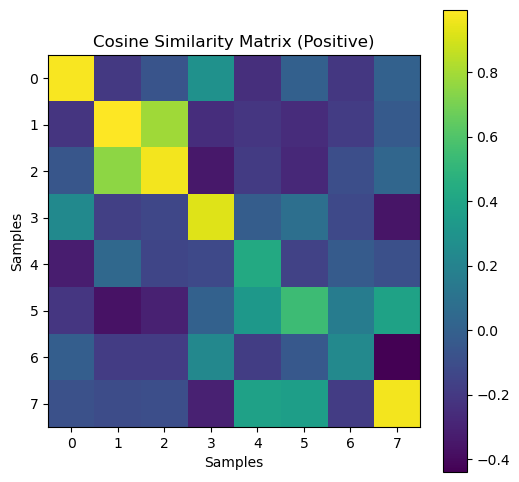

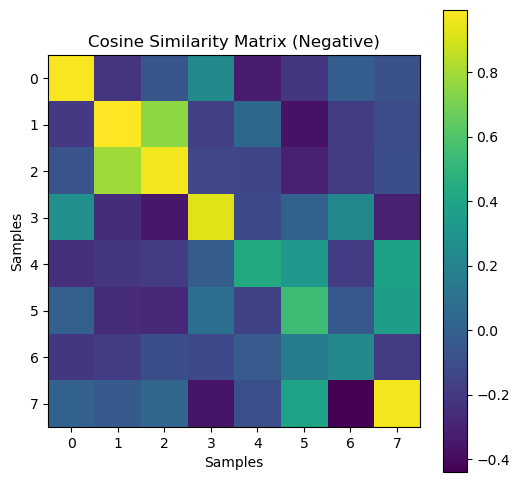

tensor([[145.8638,  89.8895],
        [140.6669,  95.2821],
        [134.7402,  90.7020],
        [158.0455, 112.3440],
        [120.6579,  84.5242],
        [116.6057,  76.5219],
        [118.8210,  79.8493],
        [182.7137, 117.0120]], device='cuda:0')


In [3]:
batch = next(iter(datamodule.train_dataloader()))
batch = [item.to(device) for item in batch]
x, channel_idx, y = batch
with torch.no_grad():
    z_pred, z_orig = model(x, channel_idx)   # (B, D)
z_pred = torch.nn.functional.normalize(z_pred, dim=-1)
z_orig = torch.nn.functional.normalize(z_orig, dim=-1)
sim_po = z_pred @ z_orig.T           # cosine similarity matrix
sim_op = z_orig @ z_pred.T           # cosine similarity matrix

# visualize similarity matrix
plt.figure(figsize=(6, 6))
plt.imshow(sim_po.cpu().numpy())
plt.colorbar()
plt.title("Cosine Similarity Matrix (Positive)")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(sim_op.cpu().numpy())
plt.colorbar()
plt.title("Cosine Similarity Matrix (Negative)")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()
print(y)

In [16]:
labels = torch.arange(z_orig.shape[0], device=z_orig.device)
print(labels)

tensor([0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')


In [3]:
z_all = []
y_all = []
for batch in datamodule.train_dataloader():
    batch = [item.to(device) for item in batch]
    x, channel_idx, y = batch
    with torch.no_grad():
        z = model(x, channel_idx)
    z_all.append(z.detach().cpu())
    y_all.append(y.detach().cpu())
z_all = torch.cat(z_all, dim=0).numpy()
y_all = torch.cat(y_all, dim=0).numpy()
print(z_all.shape, y_all.shape)

(11486, 256) (11486, 2)


In [4]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np

X = z_all if hasattr(z_all, "detach") else np.asarray(z_all)
y = y_all[:, 0]

model = make_pipeline(
    StandardScaler(),
    SVR(kernel="rbf", C=10, epsilon=0.1, gamma="scale")
)
model.fit(X, y)
pred = model.predict(X)
print("Train MAE:", mean_absolute_error(y, pred))


Train MAE: 8.631002481684218
